#### Notes for grader
- The model was trained on M1 Pro `cpu`, but believed to be working with `cuda` backend as well, unfortunately, there seems to be some issues of implementation in scapy and `mps` backend does not work as of now.
- Results/ Clusters shape and size may vary with each run due to random seed. 
- I have all of the dependencies locked with `poetry` locally, If anything does not work as expected please contact at `keval.pipalia@mail.mcgill.ca`. I can provide configurations used to regenerate the results.
- You may get different topic indices matching with different cell types as the order of topics are not the same at different runs.


Thank You and have a great day!

In [1]:
# Turn off annoying future warnings from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pickle
import numpy as np
import pandas as pd

import scanpy as sc
import anndata
import random

import torch
from torch import optim
from torch.nn import functional as F

import os
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from seaborn import heatmap, lineplot, clustermap
import seaborn as sns
from sklearn.metrics import adjusted_rand_score
from etm import ETM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current backend is: ", device)
random.seed(10)

Current backend is:  cpu


In [3]:
# mouse pancreas single-cell dataset
# read in data and cell type labels
with open('data/MP.pickle', 'rb') as f:
    df = pickle.load(f)

with open('data/MP_genes.pickle', 'rb') as f:
    genes = pickle.load(f)
    
df.set_index('Unnamed: 0', inplace=True)  # set first column (cell ID as the index column)
sample_id = pickle.load(open('data/cell_IDs.pkl', 'rb'))
df = df.loc[list(sample_id), :]

X = df[genes].values  # extract the N x M cells-by-genes matrix

sample_info = pd.read_csv('data/sample_info.csv')

mp_anndata = anndata.AnnData(X=X)

mp_anndata.obs['Celltype'] = sample_info['assigned_cluster'].values

N = X.shape[0]  # number of single-cell samples
K = 16  # number of topics
M = X.shape[1]  # number of genes

X_tensor = torch.from_numpy(np.array(X, dtype="float32"))
sums = X_tensor.sum(1).unsqueeze(1)
X_tensor_normalized = X_tensor / sums

In [4]:
def evaluate_ari(cell_embed, adata):
    """
        This function is used to evaluate ARI using the lower-dimensional embedding
        cell_embed of the single-cell data
        :param cell_embed: a NxK single-cell embedding generated from NMF or scETM
        :param adata: single-cell AnnData data object (default to to mp_anndata)
        :return: ARI score of the clustering results produced by Louvain
    """
    adata.obsm['cell_embed'] = cell_embed
    sc.pp.neighbors(adata, use_rep="cell_embed", n_neighbors=30)
    sc.tl.louvain(adata, resolution=0.15)
    ari = adjusted_rand_score(adata.obs['Celltype'], adata.obs['louvain'])
    return ari

In [5]:
model = ETM(num_topics=K,
            vocab_size=len(genes),
            t_hidden_size=256,
            rho_size=256,
            theta_act='relu',
            embeddings=None,
            train_embeddings=True,
            enc_drop=0.5).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1.2e-6)

In [6]:
# train the VAE for one epoch
def train_scETM_helper(model, X_tensor, X_tensor_normalized):
    # initialize the model and loss
    model.train()
    optimizer.zero_grad()
    model.zero_grad()

    # forward and backward pass
    nll, kl_theta = model(X_tensor, X_tensor_normalized)
    loss = nll + kl_theta
    loss.backward()  # backprop gradients w.r.t. negative ELBO

    # clip gradients to 2.0 if it gets too large
    torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)

    # update model to minimize negative ELBO
    optimizer.step()

    return torch.sum(loss).item()


# get sample encoding theta from the trained encoder network
def get_theta(model, input_x):
    model.eval()
    with torch.no_grad():
        q_theta = model.q_theta(input_x)
        mu_theta = model.mu_q_theta(q_theta)
        theta = F.softmax(mu_theta, dim=-1)
        return theta

# Q1 Train ETM on mouse pancreas scRNA-seq data

In [7]:
def train_scETM(model, X_tensor, X_tensor_normalized, adata=mp_anndata, niter=1000):
    """
        :param model: the scETM model object
        :param X_tensor: NxM raw read count matrix X
        :param X_tensor_normalized: NxM normalized read count matrix X
        :param adata: annotated single-cell data object with ground-truth cell type information for evaluation
        :param niter: maximum number of epochs
        :return:
            1. model: trained scETM model object
            2. perf: niter-by-3 ndarray with iteration index, NELBO, and ARI as the 3 columns
    """
    perf = np.ndarray(shape=(niter, 3), dtype='float')
    
    # WRITE YOUR CODE HERE
    
    for iter in range(niter) :
        loss = train_scETM_helper(model, X_tensor, X_tensor_normalized)
        with torch.no_grad():
            theta = get_theta(model, X_tensor_normalized)
            ari = evaluate_ari(theta, adata)
            
        perf[iter, 0] = iter
        perf[iter, 1] = loss
        perf[iter, 2] = ari

        if iter % 10 == 0:  # print out performance every 10 iterations
            print(f'Iter: {iter}, Loss: {loss:.4f}, ARI: {ari:.4f}')

    return model, perf

def monitor_perf(perf, objective, path=""):
    """
    :param perf: niter-by-3 ndarray with iteration index, objective function, and ARI as the 3 columns
    :param objective: 'NELBO'
    :param path: path to save the figure if not display to the screen
    :behaviour: display or save a 2-by-1 plot showing the progress of optimizing objective and ARI as
        a function of iterations
    """
    # WRITE YOUR CODE HERE
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    
    # Plot Negative ELBO
    axes[0].plot(perf[:, 0], perf[:, 1], label='Negative ELBO')
    axes[0].set_title('Training Negative ELBO')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel(objective)
    axes[0].legend()

    # Plot ARI
    axes[1].plot(perf[:, 0], perf[:, 2], label='ARI', color='orange')
    axes[1].set_title('ARI Across Iterations')
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('ARI')
    axes[1].legend()

    plt.tight_layout()

    if path:
        plt.savefig(path)
    else:
        plt.show()

In [8]:
model, scetm_perf = train_scETM(model, X_tensor, X_tensor_normalized, niter=1000)

/Users/kevalpipalia/Keval/VAE-on-Mouse-Pancreas-single-cell-RNA-sequencing-data/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iter: 0, Loss: 9645.6406, ARI: 0.5839
Iter: 10, Loss: 9339.3438, ARI: 0.8403
Iter: 20, Loss: 9011.4102, ARI: 0.5251
Iter: 30, Loss: 8726.5547, ARI: 0.4382
Iter: 40, Loss: 8494.8730, ARI: 0.4300
Iter: 50, Loss: 8266.7607, ARI: 0.4193
Iter: 60, Loss: 8088.0581, ARI: 0.4826
Iter: 70, Loss: 7953.3774, ARI: 0.4048
Iter: 80, Loss: 7855.7251, ARI: 0.4175
Iter: 90, Loss: 7793.1777, ARI: 0.4287
Iter: 100, Loss: 7749.5942, ARI: 0.3428
Iter: 110, Loss: 7718.4683, ARI: 0.3617
Iter: 120, Loss: 7687.8379, ARI: 0.4846
Iter: 130, Loss: 7650.5503, ARI: 0.3734
Iter: 140, Loss: 7611.7764, ARI: 0.4713
Iter: 150, Loss: 7577.2993, ARI: 0.3821
Iter: 160, Loss: 7549.1621, ARI: 0.3284
Iter: 170, Loss: 7526.0688, ARI: 0.4089
Iter: 180, Loss: 7506.9365, ARI: 0.3920
Iter: 190, Loss: 7494.4458, ARI: 0.5280
Iter: 200, Loss: 7483.3516, ARI: 0.4503
Iter: 210, Loss: 7471.9258, ARI: 0.5657
Iter: 220, Loss: 7463.7539, ARI: 0.5592
Iter: 230, Loss: 7454.4580, ARI: 0.5846
Iter: 240, Loss: 7445.8936, ARI: 0.5747
Iter: 250, 

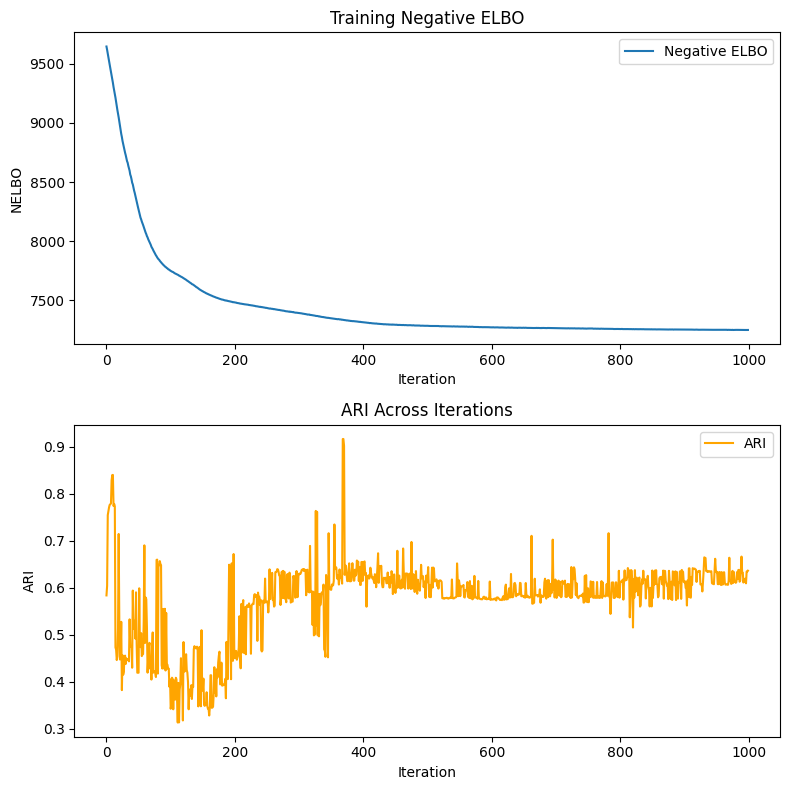

In [9]:
monitor_perf(scetm_perf, "NELBO")

# Q2 Plot t-SNE or UMAP

/Users/kevalpipalia/Keval/VAE-on-Mouse-Pancreas-single-cell-RNA-sequencing-data/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


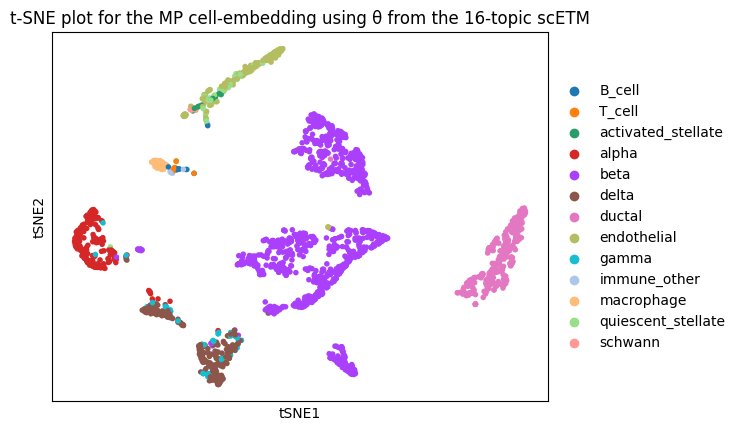

/Users/kevalpipalia/Keval/VAE-on-Mouse-Pancreas-single-cell-RNA-sequencing-data/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


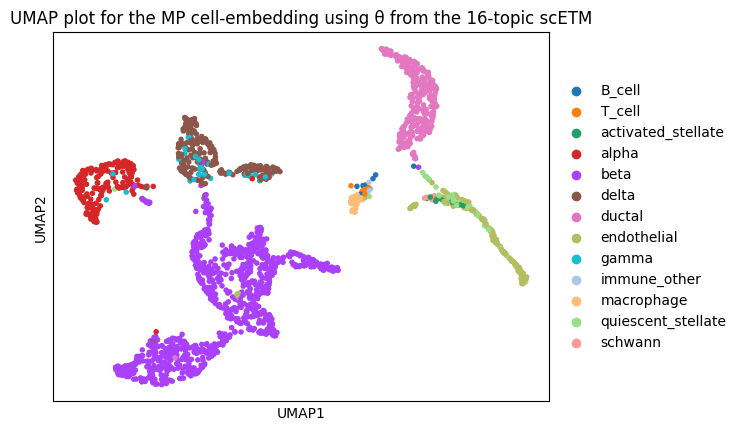

In [37]:
# WRITE YOUR CODE HERE

# Extracting the final cell topic embedding θ for the visualization
with torch.no_grad():
    cell_embeddings = get_theta(model, X_tensor_normalized).cpu().numpy()

# Adding the cell embeddings to the AnnData object
mp_anndata.obsm['X_scETM'] = cell_embeddings

# Running t-SNE
sc.tl.tsne(mp_anndata, use_rep='X_scETM')

# Running UMAP
sc.pp.neighbors(mp_anndata, use_rep='X_scETM', n_neighbors=30)
sc.tl.umap(mp_anndata)

# Plotting the t-SNE results
sc.pl.tsne(mp_anndata, color='Celltype', title='t-SNE plot for the MP cell-embedding using θ from the 16-topic scETM')

# Plotting the UMAP results
sc.pl.umap(mp_anndata, color='Celltype', title='UMAP plot for the MP cell-embedding using θ from the 16-topic scETM')


# Q3 plot cells by topics

In [11]:
def create_celltype_color_palette(unique_cell_types):
    """Create a color palette based on unique cell types."""
    palette = sns.color_palette('husl', len(unique_cell_types))  # Husl palette for distinct colors
    return dict(zip(unique_cell_types, palette))

In [20]:
cell_types = mp_anndata.obs['Celltype']

In [21]:
theta_df = pd.DataFrame(theta, columns=[f'{i}' for i in range(K)])

In [22]:
theta_df['Celltype'] = np.array(cell_types.values)

In [23]:
# Create a color palette, which is a dictionary mapping the cell type to a color
unique_cell_types = theta_df['Celltype'].unique()
palette = sns.color_palette('husl', len(unique_cell_types))  # Adjust the color palette as needed
celltype_palette = dict(zip(unique_cell_types, palette))

In [24]:
# Map the cell types to colors and create a row_colors list
# import pdb; pdb.set_trace()
row_colors = theta_df['Celltype'].map(celltype_palette)
theta_df = theta_df.drop(columns='Celltype'),  # Exclude the 'Celltype' column from the heatmap

/Users/kevalpipalia/Keval/VAE-on-Mouse-Pancreas-single-cell-RNA-sequencing-data/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/kevalpipalia/Keval/VAE-on-Mouse-Pancreas-single-cell-RNA-sequencing-data/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


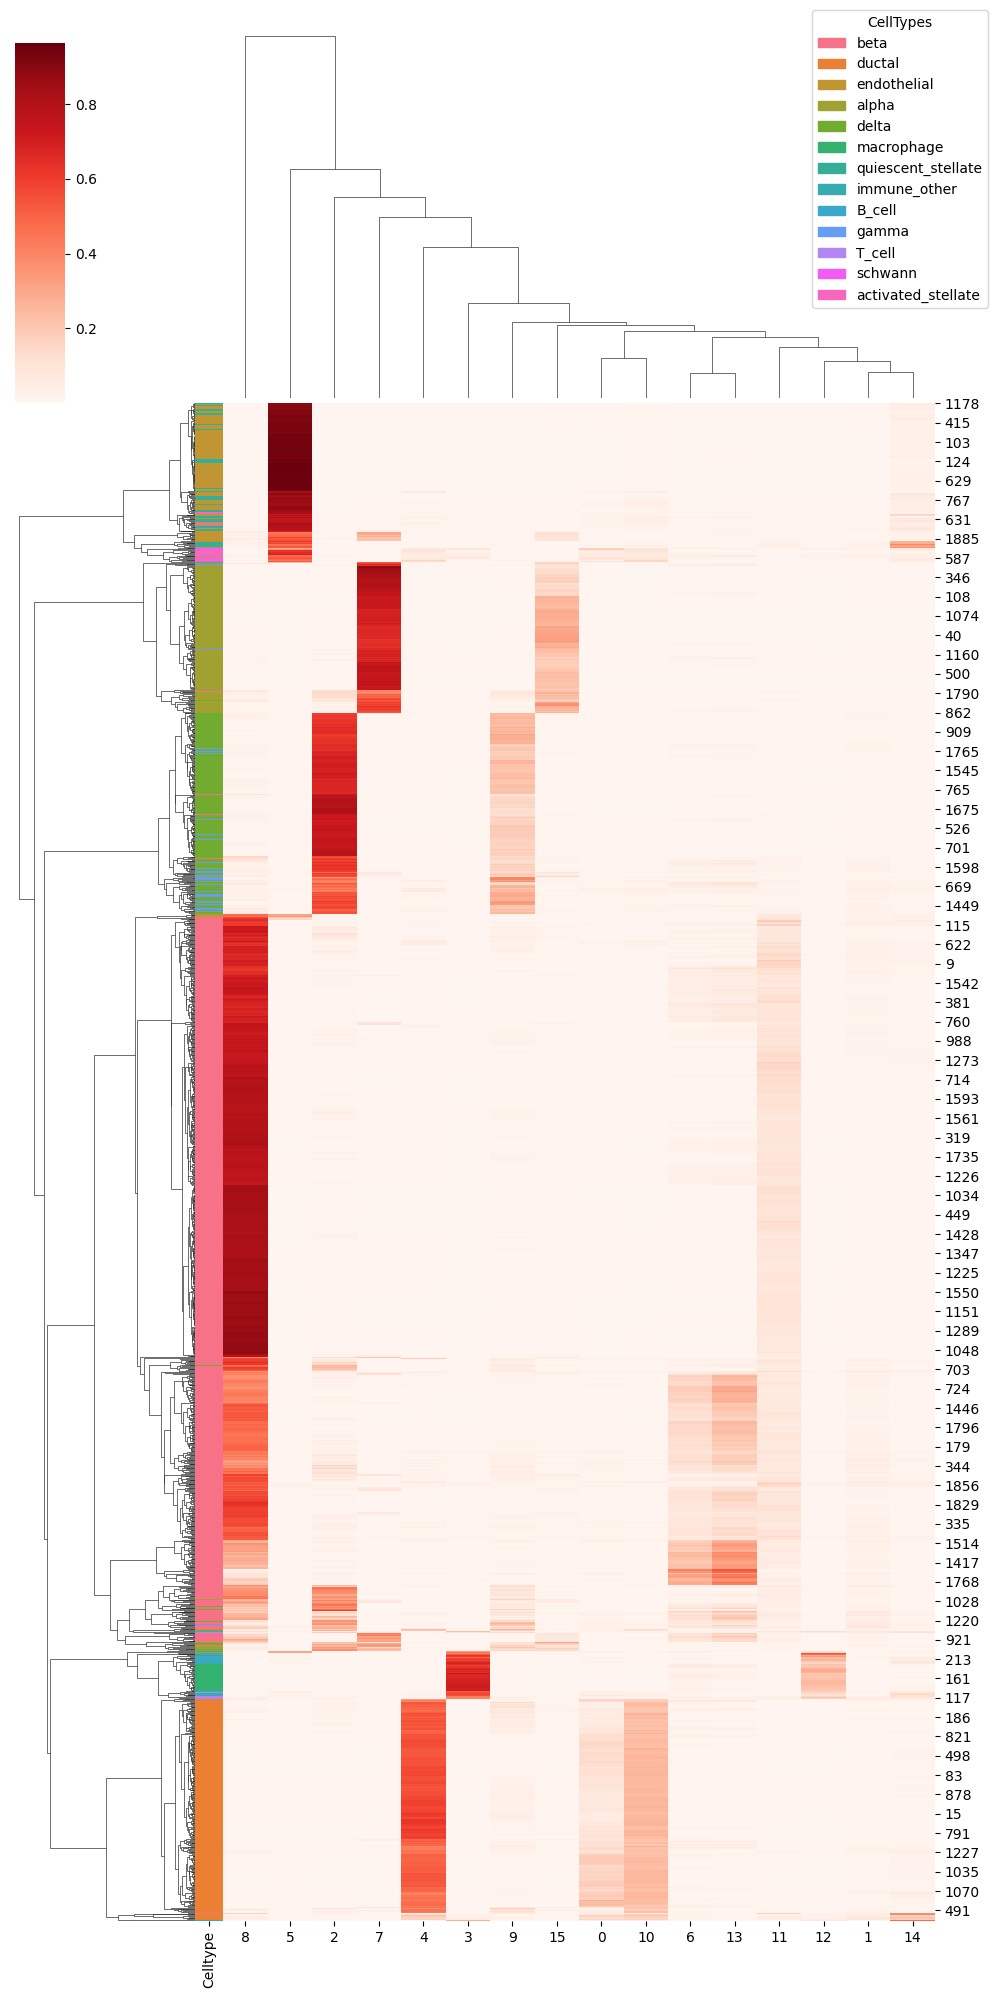

In [25]:
# Generate the clustermap
sns.clustermap(theta_df[0],
    row_colors= row_colors,  # Use the row_colors we just defined
    method='average',
    cmap='Reds',  # Same colormap as in Figure 4
    figsize=(10, 20)  # Adjust the figure size to match the desired layout
)


# Create a legend for the cell types with a color patch
legend_patches = [Patch(color=celltype_palette[cell_type], label=cell_type) 
                  for cell_type in unique_cell_types]
# Place the legend in the plot
# plt.legend(handles=legend_patches, title='Cell Type', loc='upper right')
plt.legend(handles=legend_patches, title='CellTypes',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.show()

# Q4 Plot genes-by-topics

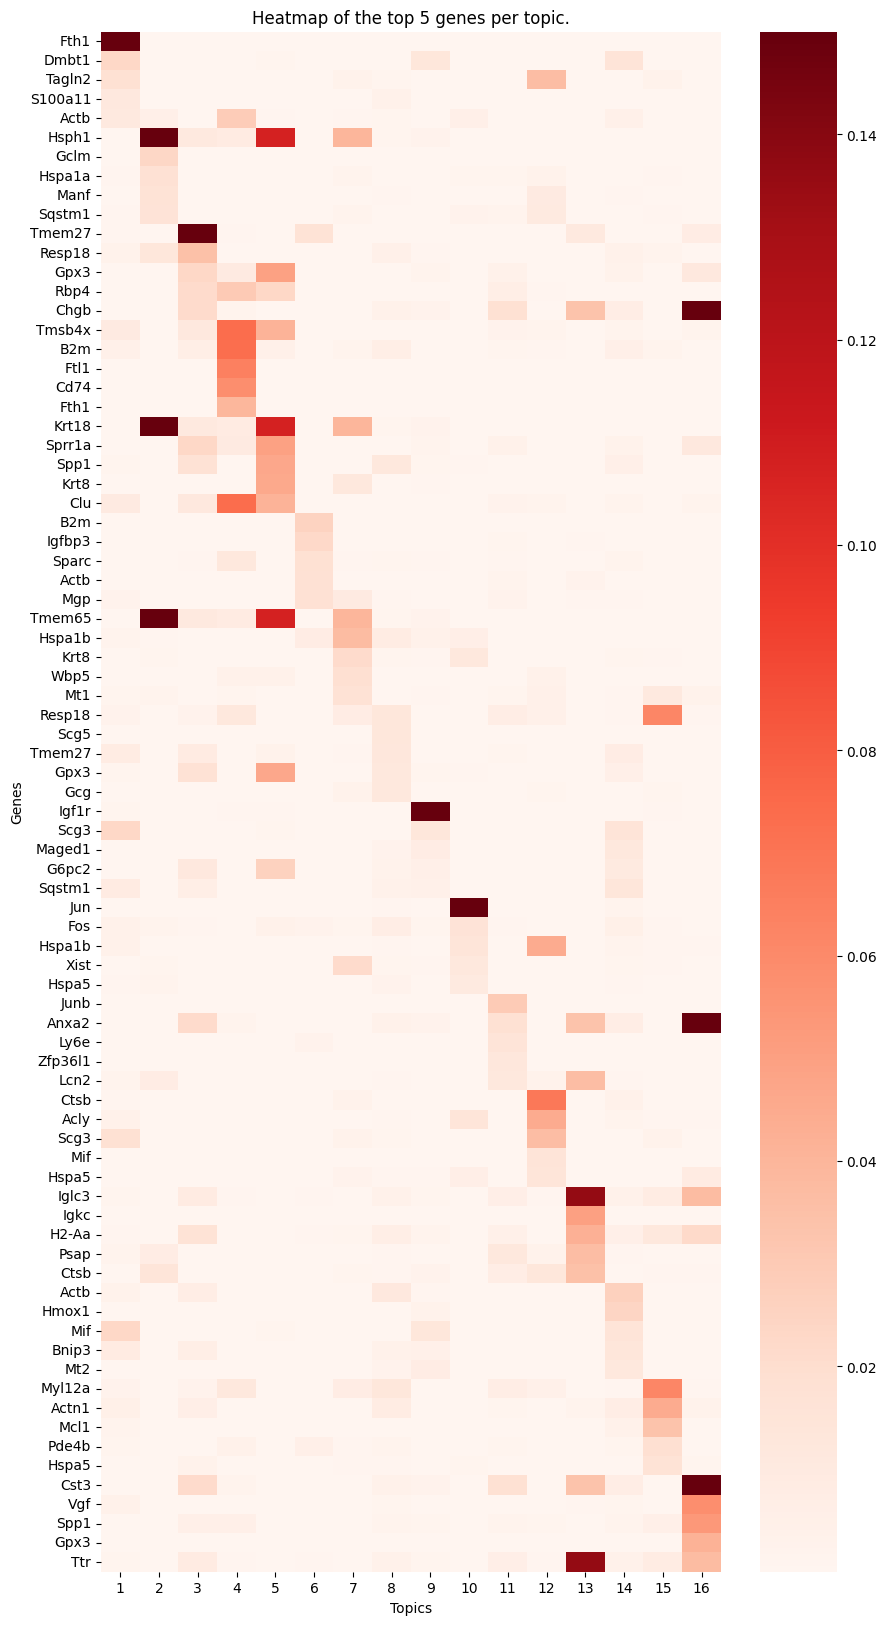

In [26]:
# WRITE YOUR CODE HERE
# Get the beta matrix
with torch.no_grad():
    beta = model.get_beta().cpu().numpy()  # Ensure it's on CPU and convert to numpy

# Now, for each topic, find the indices of the top 5 genes
sorted_indices = np.argsort(beta, axis=1) 
top_gene_indices_per_topic = np.flip(sorted_indices[:, -5:])

# Create list or array of gene names for the top 5 genes of every topic
gene_names = genes.values  
top_genes_names = np.array(gene_names)[top_gene_indices_per_topic]# Map indices to names
top_genes_names_flattened = top_genes_names.flatten()

#Get the top gene values using the found top gene indices
top_genes_values = beta[:, top_gene_indices_per_topic.flatten()].T  # Transpose to align with the flattened indices

# Flatten the top gene names for the index of the new DataFrame
top_genes_names_flattened = np.array(gene_names)[top_gene_indices_per_topic.flatten()]

# Create a new empty DataFrame with these gene names as the index
new_df = pd.DataFrame(index=top_genes_names_flattened, columns=[f'Topic_{i+1}' for i in range(beta.shape[0])])

# Now fill in the new DataFrame with the top genes values:
for i, gene_name in enumerate(top_genes_names_flattened):
    new_df.loc[gene_name] = top_genes_values[i]

new_df = new_df.apply(pd.to_numeric)

# Plot the heatmap using seaborn
plt.figure(figsize=(10, 20))
sns.heatmap(
    new_df.iloc[:, ::-1],
    vmax = 0.15,
    fmt=".3f",  # Formatting to 3 decimal places
    yticklabels=np.flip(top_genes_names_flattened.flatten()),  # Gene names as y-ticks
    xticklabels=[f'{i+1}' for i in range(model.num_topics)],
    cmap="Reds"
)
plt.title('Heatmap of the top 5 genes per topic.')
plt.xlabel('Topics')
plt.ylabel('Genes')
plt.show()

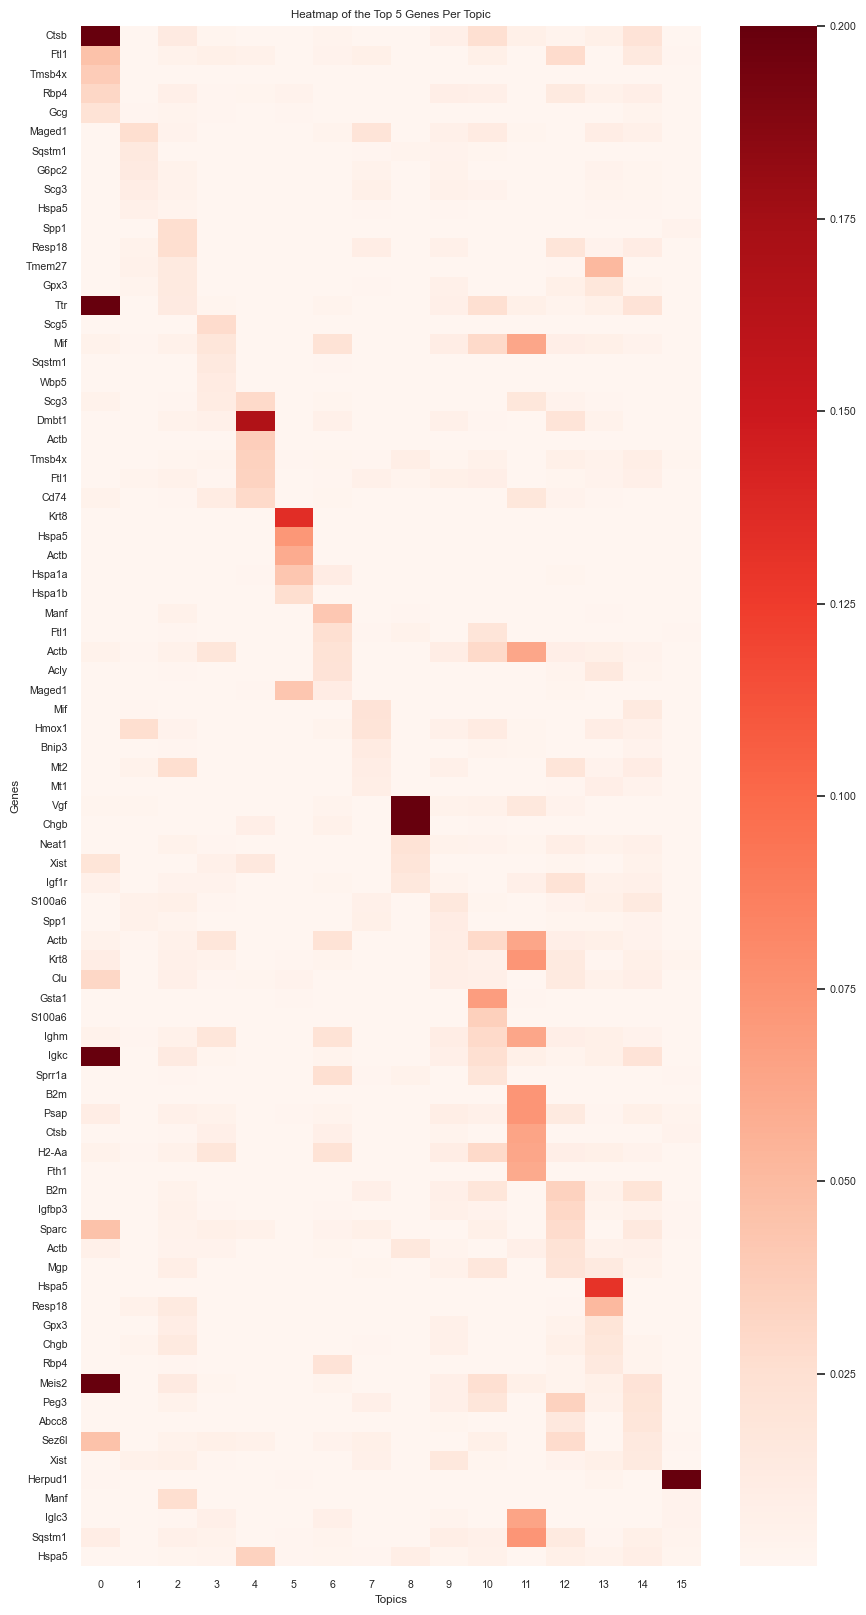

In [179]:
with torch.no_grad():
    topic_gene_matrix = model.get_beta().cpu().numpy()

topic_gene_sorted_indices = np.argsort(topic_gene_matrix, axis=1)
top_five_genes_indices = np.flip(topic_gene_sorted_indices[:, -5:])

gene_names_array = genes.values
top_genes_names_per_topic = gene_names_array[top_five_genes_indices]

top_genes_values = topic_gene_matrix[:, top_five_genes_indices.flatten()].T

gene_names_flat = top_genes_names_per_topic.flatten()
topics_columns = [f'Topic_{i}' for i in range(topic_gene_matrix.shape[0])]
top_genes_df = pd.DataFrame(index=gene_names_flat, columns=topics_columns)


for i, gene_name in enumerate(gene_names_flat):
    top_genes_df.loc[gene_name] = top_genes_values[i]

top_genes_df = top_genes_df.apply(pd.to_numeric)

plt.figure(figsize=(10, 20))
sns.heatmap(
    top_genes_df.iloc[:, ::-1],
    vmax=0.2,
    cmap="Reds",
    yticklabels=np.flip(gene_names_flat),
    xticklabels=[f'{i}' for i in range(model.num_topics)],
)
plt.title('Heatmap of the Top 5 Genes Per Topic')
plt.xlabel('Topics')
plt.ylabel('Genes')
plt.show()

In [ ]:
# One can analyze the results for every topic from this heatmap, for example for topic 0 which refers to alpha cell type, The genes 

In [177]:
gene_names_flat

array(['Hspa5', 'Sqstm1', 'Iglc3', 'Manf', 'Herpud1', 'Xist', 'Sez6l',
       'Abcc8', 'Peg3', 'Meis2', 'Rbp4', 'Chgb', 'Gpx3', 'Resp18',
       'Hspa5', 'Mgp', 'Actb', 'Sparc', 'Igfbp3', 'B2m', 'Fth1', 'H2-Aa',
       'Ctsb', 'Psap', 'B2m', 'Sprr1a', 'Igkc', 'Ighm', 'S100a6', 'Gsta1',
       'Clu', 'Krt8', 'Actb', 'Spp1', 'S100a6', 'Igf1r', 'Xist', 'Neat1',
       'Chgb', 'Vgf', 'Mt1', 'Mt2', 'Bnip3', 'Hmox1', 'Mif', 'Maged1',
       'Acly', 'Actb', 'Ftl1', 'Manf', 'Hspa1b', 'Hspa1a', 'Actb',
       'Hspa5', 'Krt8', 'Cd74', 'Ftl1', 'Tmsb4x', 'Actb', 'Dmbt1', 'Scg3',
       'Wbp5', 'Sqstm1', 'Mif', 'Scg5', 'Ttr', 'Gpx3', 'Tmem27', 'Resp18',
       'Spp1', 'Hspa5', 'Scg3', 'G6pc2', 'Sqstm1', 'Maged1', 'Gcg',
       'Rbp4', 'Tmsb4x', 'Ftl1', 'Ctsb'], dtype=object)

/Users/kevalpipalia/Keval/VAE-on-Mouse-Pancreas-single-cell-RNA-sequencing-data/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/kevalpipalia/Keval/VAE-on-Mouse-Pancreas-single-cell-RNA-sequencing-data/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


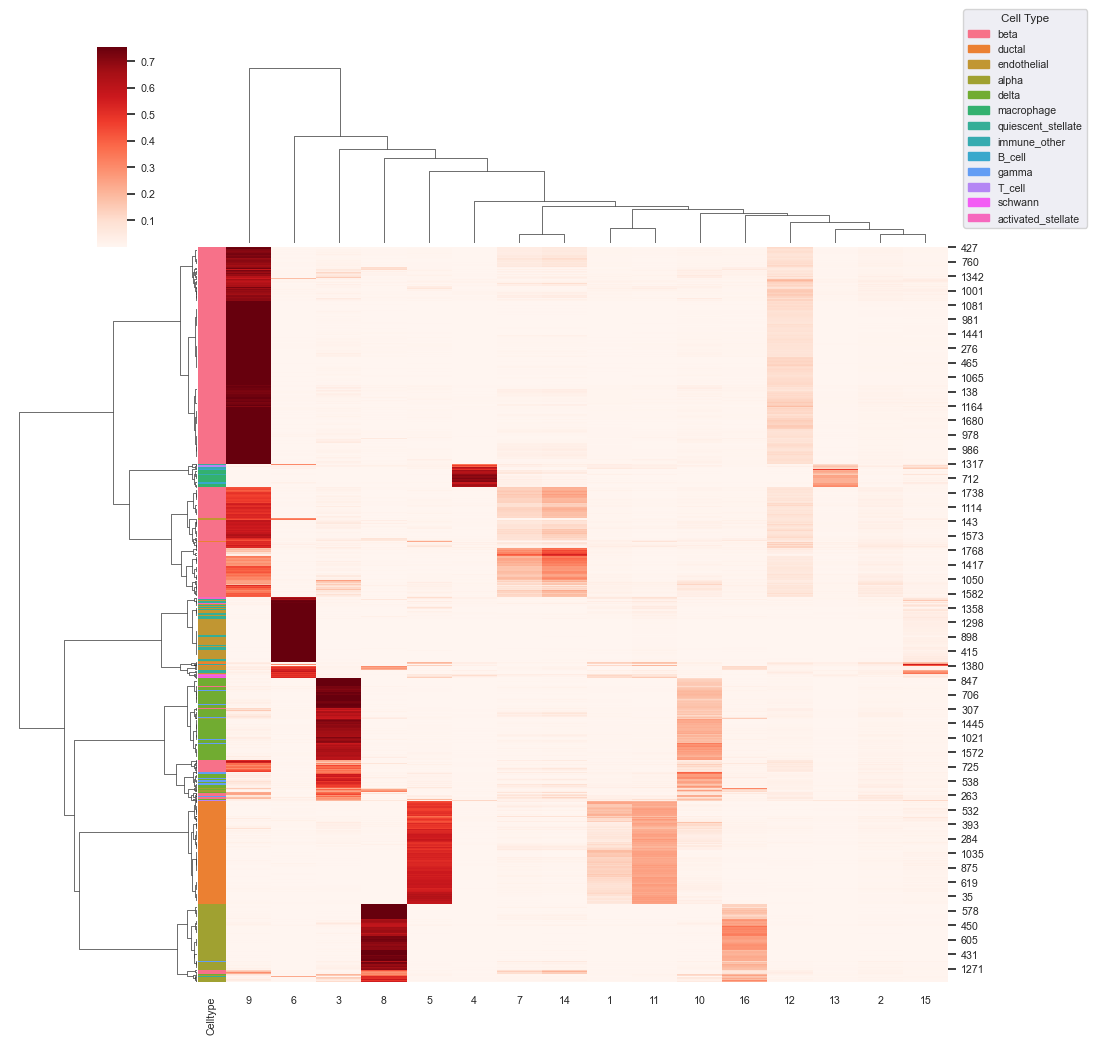

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# After training, you would get the topic distributions (theta) for all cells
theta = get_theta(model, X_tensor_normalized)

cell_types = mp_anndata.obs['Celltype']

theta_df = pd.DataFrame(theta, columns=[f'{i+1}' for i in range(K)])

theta_df['Celltype'] = np.array( cell_types.values)

# Create a color palette, which is a dictionary mapping the cell type to a color
unique_cell_types = theta_df['Celltype'].unique()
palette = sns.color_palette('husl', len(unique_cell_types))  # Adjust the color palette as needed
celltype_palette = dict(zip(unique_cell_types, palette))

# Map the cell types to colors and create a row_colors list
# import pdb; pdb.set_trace()
row_colors = theta_df['Celltype'].map(celltype_palette)

# Generate the clustermap
sns.set(font_scale=0.7)  # Adjust to fit the scale of your figure
g = sns.clustermap(
    theta_df.drop(columns='Celltype'),  # Exclude the 'Celltype' column from the heatmap
    robust=True,
    row_colors= row_colors,  # Use the row_colors we just defined
    method='ward',
    cmap='Reds',  # Same colormap as in Figure 4
    figsize=(10, 10)  # Adjust the figure size to match the desired layout
)

# Adjust the position of the main color bar
g.cax.set_position([0.1, 0.8, 0.03, 0.2])


# Create a legend for the cell types with a color patch
legend_patches = [Patch(color=celltype_palette[cell_type], label=cell_type) 
                  for cell_type in unique_cell_types]

# Place the legend in the plot
g.ax_col_dendrogram.legend(handles=legend_patches, title='Cell Type', 
                            bbox_to_anchor=(1.2, 1.3), loc='best')


plt.show()

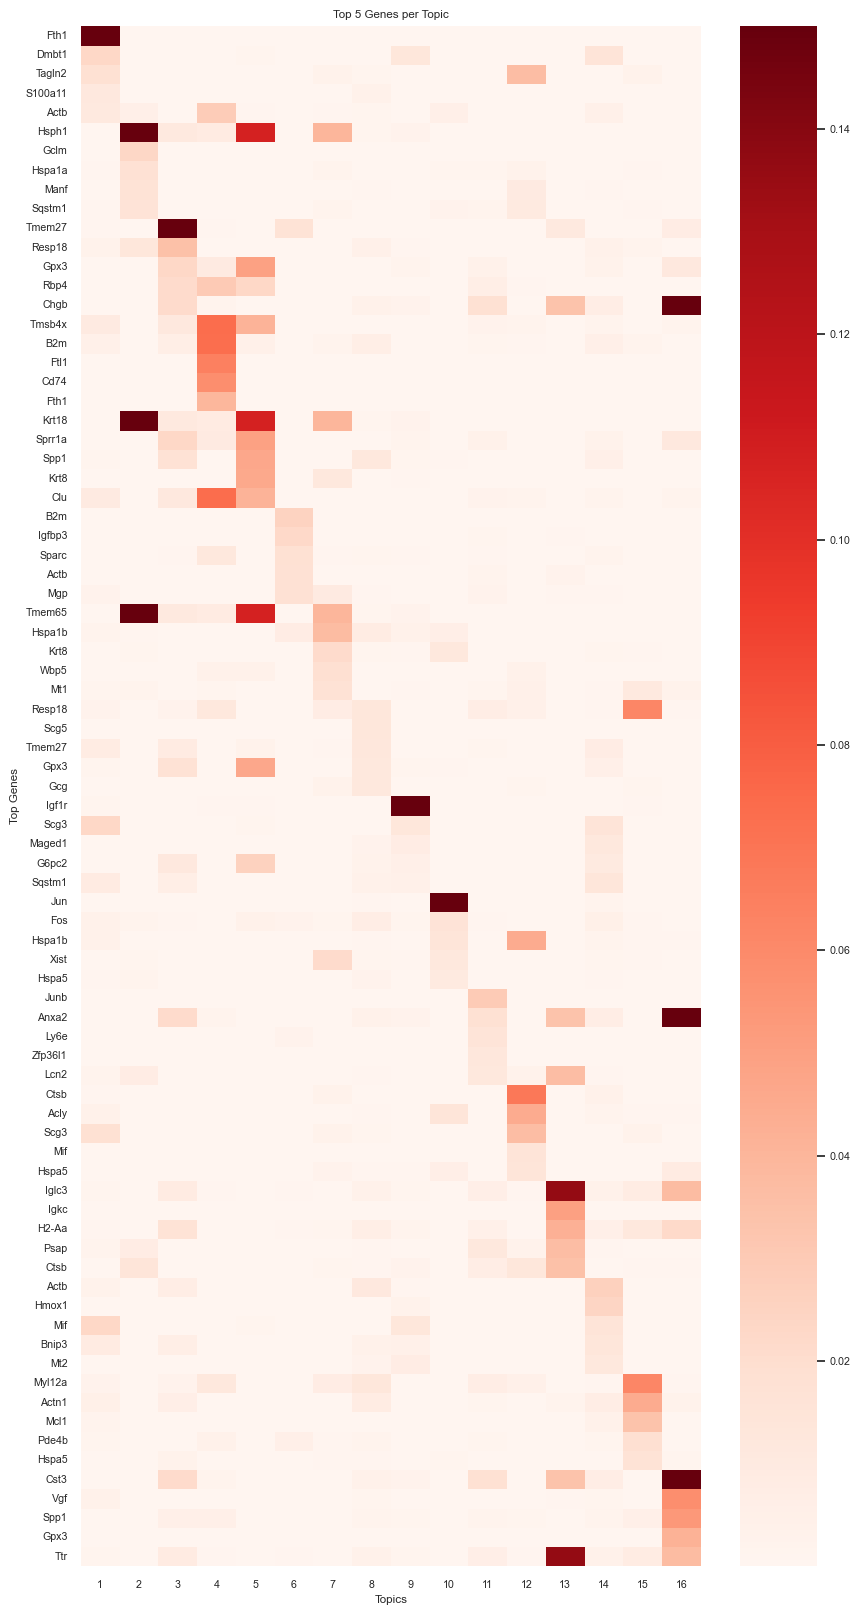

In [30]:

# Get the beta matrix
with torch.no_grad():
    beta = model.get_beta().cpu().numpy()  # Ensure it's on CPU and convert to numpy

# Now, for each topic, find the indices of the top 5 genes
sorted_indices = np.argsort(beta, axis=1) 
top_gene_indices_per_topic = np.flip(sorted_indices[:, -5:])

# Create list or array of gene names for the top 5 genes of every topic
gene_names = genes.values  
top_genes_names = np.array(gene_names)[top_gene_indices_per_topic]# Map indices to names
top_genes_names_flattened = top_genes_names.flatten()

#Get the top gene values using the found top gene indices
top_genes_values = beta[:, top_gene_indices_per_topic.flatten()].T  # Transpose to align with the flattened indices

# Flatten the top gene names for the index of the new DataFrame
top_genes_names_flattened = np.array(gene_names)[top_gene_indices_per_topic.flatten()]

# Create a new empty DataFrame with these gene names as the index
new_df = pd.DataFrame(index=top_genes_names_flattened, columns=[f'Topic_{i+1}' for i in range(beta.shape[0])])

# Now fill in the new DataFrame with the top genes values:
for i, gene_name in enumerate(top_genes_names_flattened):
    new_df.loc[gene_name] = top_genes_values[i]

new_df = new_df.apply(pd.to_numeric)

# Plot the heatmap using seaborn
plt.figure(figsize=(10, 20))
sns.heatmap(
    new_df.iloc[:, ::-1],
    vmax = 0.15,
    fmt=".3f",  # Formatting to 3 decimal places
    yticklabels=np.flip(top_genes_names_flattened.flatten()),  # Gene names as y-ticks
    xticklabels=[f'{i+1}' for i in range(model.num_topics)],
    cmap="Reds"
)
plt.title('Top 5 Genes per Topic')
plt.xlabel('Topics')
plt.ylabel('Top Genes')
plt.show()